In [1]:
%matplotlib inline

# Filter warnings
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from pyod.models.pca import PCA as PCAOD
from pyod.models.cblof import CBLOF
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import OneClassSVM as OCSVM
from sklearn.ensemble import IsolationForest
#from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
import csv
import pandas as pd
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from pyod.models.iforest import IForest
from pyod.models.ecod import ECOD
from pyod.models.dif import DIF
from pyod.models.lof import LOF
from pyod.models.cblof import CBLOF
from pyod.models.cof import COF
     

from sklearn.decomposition import PCA

from deepod.models.tabular import DeepSVDD, DeepIsolationForest, ICL, GOAD, RCA, RDP
from deepod.models.time_series import AnomalyTransformer, TimesNet, DeepIsolationForestTS, DCdetector, USAD
import torch
import holidays

tw_holidays = holidays.country_holidays('TW')

#from .unsup import UnsupervisedModels

#from .src.transfxns import TransformationPipeline

plt.rcParams.update({'font.size': 15})

# Import us custom classes
# %run -i '../src/transfxns.py'
# %run -i '../src/unsup_ml.py'
# Import ss custom class
# %run -i '../src/ss_transfxns.py'
# %run -i '../src/ss_ml.py'
# %run -i '../src/sup_ml.py'

%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Instantiate the classes of unspervised learning
# transfxn = TransformationPipeline()
#model = UnsupervisedModels()
scaler = StandardScaler()

# Instantiate the class of semi-supervised learning
# transfxn_ss = TransformationPipelineSS()
# model_ss = SemiSupervised()

print(torch.cuda.is_available())

2024-02-17 11:35:06.532127: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-17 11:35:06.534225: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-17 11:35:06.574124: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-17 11:35:06.574760: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-17 11:35:07.256547: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

False


# Define Model

In [2]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import average_precision_score


class UnsupervisedModels:
    """Unsupervised ML models."""

    def __init__(self):
        """Parameter initialization."""
        pass

    def iforest(self, X_train, n_estimators=None, random_state=None):
        """Train Isolation Forest from scikit-learn.

        Parameters
        ----------
        X_train: scaled training data
        n_estimators: number of isolation trees
        random_state: random number seed

        Returns
        -------
        Anomaly scores
        """
        model = IsolationForest(
            n_estimators=n_estimators,
            max_samples='auto',
            random_state=random_state,
        )
        model.fit(X_train)

        # predict raw anomaly score
        labels = model.predict(X_train)   # -1 for outliers and 1 for inliers
        labels = (labels.max() - labels) // 2   # 1: outliers, 0: inliers
        iforest_anomaly_scores = model.decision_function(X_train) * -1
        iforest_anomaly_scores = self.min_max_scaler(iforest_anomaly_scores)
        return iforest_anomaly_scores, labels

    def cblof(self, X_train, contamination=None, random_state=None):
        """Train CBLOF model from PYOD.

        Parameters
        ----------
        X_train: scaled training data
        contamination: percentage of anomalies in the data
        random_state: random number seed

        Returns
        -------
        Anomaly scores
        """
        model = CBLOF(contamination=contamination, random_state=random_state)
        model.fit(X_train)

        # predict raw anomaly score
        labels = model.predict(X_train)   # outlier labels (0 or 1)
        cblof_anomaly_scores = model.decision_function(X_train)
        cblof_anomaly_scores = self.min_max_scaler(cblof_anomaly_scores)
        return cblof_anomaly_scores, labels

    def ocsvm(self, X_train, kernel=None, gamma=None, nu=None):
        """Train OCSVM model from Sklearn.

        Parameters
        ----------
        X_train: scaled training data
        kernel: kernel funcs: linear, poly, rbf, sigmoid
        gamma: kernel coefficient for rbf, poly and sigmoid
        nu: regularization parameter btw [0,1]

        Returns
        -------
        Anomaly scores
        """
        model = OCSVM(kernel=kernel, gamma=gamma, nu=nu)
        model.fit(X_train)

        # predict raw anomaly score
        labels = model.predict(X_train)  # Outlier labels (-1 or 1)
        labels = (labels.max() - labels) // 2   # 1: outliers, 0: inliers
        ocsvm_anomaly_scores = model.decision_function(X_train) * -1
        ocsvm_anomaly_scores = self.min_max_scaler(ocsvm_anomaly_scores)
        return ocsvm_anomaly_scores, labels

    def cov(self, X_train, contamination=None, random_state=None):
        """Train Elliptic Envelope model from scikit-learn.

        Parameters
        ----------
        X_train: scaled training data
        contamination: percentage of anomalies in the data
        random_state: random number seed

        Returns
        -------
        Anomaly scores
        """
        model = EllipticEnvelope(
            contamination=contamination, random_state=random_state
        )
        model.fit(X_train)

        # predict raw anomaly score
        labels = model.predict(X_train)   # -1 for outliers and 1 for inliers
        labels = (labels.max() - labels) // 2   # 1: outliers, 0: inliers)
        cov_anomaly_scores = model.decision_function(X_train) * -1
        cov_anomaly_scores = self.min_max_scaler(cov_anomaly_scores)
        return cov_anomaly_scores, labels

    def pca(self, X_train, n_components=None, contamination=None):
        """Train PCA model from PYOD.

        Parameters
        ----------
        X_train: scaled training data
        contamination: percentage of anomalies in the data
        n_components: number of components to transform

        Returns
        -------
        Anomaly scores
        """
        model = PCAOD(n_components=n_components, contamination=contamination)
        model.fit(X_train)

        # predict raw anomaly score
        labels = model.predict(X_train)  # outlier labels (0 or 1)
        pca_anomaly_scores = model.decision_function(
            X_train
        )   # outlier scores
        pca_anomaly_scores = self.min_max_scaler(pca_anomaly_scores)
        return pca_anomaly_scores, labels

    def eval_metric(self, y_true, y_pred, model_nm=None):
        """Evaluation metric using the ground truth and the predicted labels.

        Parameters
        ----------
        y_pred: predicted labels
        y_true: true labels
        model_nm: name of model

        Returns
        -------
        Performance metrics
        """
        print(f'Test predictions for {str(model_nm)}')
        print('-' * 60)
        print('Accuracy:  %f' % (accuracy_score(y_true, y_pred)))
        print('AUROC: %f' % (roc_auc_score(y_true, y_pred)))
        print('AUPRC: %f' % (average_precision_score(y_true, y_pred)))
        print('Predicted classes:', np.unique(y_pred))
        print('Confusion matrix:\n', confusion_matrix(y_true, y_pred))
        print(
            'Classification report:\n', classification_report(y_true, y_pred)
        )
        print('-' * 60)

    def min_max_scaler(self, arr):
        """Min-Max normalization to rescale the anomaly scores.

        Parameters
        ----------
        arr: 1d array

        Returns
        -------
        normalized array in the range [0,100]
        """
        scaler = (arr - np.min(arr)) * 100 / (np.max(arr) - np.min(arr))
        return scaler

    def plot_dist(self, scores, color=None, title=None):
        """Plot the distribution of anomaly scores.

        Parameters
        ----------
        scores: scaled anomaly scores

        Returns
        -------
        seaborn distribution plot
        """
        # figure layout
        plt.rcParams.update({'font.size': 15})
        plt.subplots(figsize=(8, 6))

        # plot distribution with seaborn
        sns.distplot(scores, color=color)
        plt.title(label=title)
        plt.xlabel('Normalized anomaly scores')
        plt.show()
class TransformationPipeline:
    """Transformation pipeline for supervised learning."""

    def __init__(self):
        """Define parameters."""
        pass

    def num_pipeline(self, X_train, X_test):
        """Transformation pipeline of data with only numerical variables.

        Parameters
        ----------
        X_train: training feature matrix
        X_test: test feature matrix

        Returns
        -------
        Transformation pipeline and transformed data in array
        """
        # create pipeline
        num_pipeline = Pipeline(
            [
                ('std_scaler', StandardScaler()),
            ]
        )

        # original numerical feature names
        feat_nm = list(X_train.select_dtypes('number'))

        # fit transform the training set and transform the test set
        X_train_scaled = num_pipeline.fit_transform(X_train)
        X_test_scaled = num_pipeline.transform(X_test)
        return X_train_scaled, X_test_scaled, feat_nm

    def cat_pipeline(self, X_train, X_test):
        """Transformation pipeline of categorical variables.

        Parameters
        ----------
        X_train: training feature matrix
        X_test: test feature matrix

        Returns
        -------
        Transformation pipeline and transformed data in array
        """
        # instatiate class
        one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

        # fit transform the training set and transform the test set
        X_train_scaled = one_hot_encoder.fit_transform(X_train)
        X_test_scaled = one_hot_encoder.transform(X_test)

        # feature names for output features
        feat_nm = list(
            one_hot_encoder.get_feature_names_out(
                list(X_train.select_dtypes('O'))
            )
        )
        return X_train_scaled.toarray(), X_test_scaled.toarray(), feat_nm

    def preprocessing(self, X_train, X_test):
        """Transformation pipeline of data with both
        numerical and categorical variables.

        Parameters
        ----------
        X_train: training feature matrix
        X_test: test feature matrix

        Returns
        -------
        Transformed data in array
        """

        # numerical transformation pipepline
        num_train, num_test, num_col = self.num_pipeline(
            X_train.select_dtypes('number'), X_test.select_dtypes('number')
        )

        # categorical transformation pipepline
        cat_train, cat_test, cat_col = self.cat_pipeline(
            X_train.select_dtypes('O'), X_test.select_dtypes('O')
        )

        # transformed training and tes set
        X_train_scaled = np.concatenate((num_train, cat_train), axis=1)
        X_test_scaled = np.concatenate((num_test, cat_test), axis=1)

        # feature names
        feat_nm = num_col + cat_col
        return X_train_scaled, X_test_scaled, feat_nm

    def preprocessing_2(self, X_train, X_test):
        """This preprocessing uses scikit-learn ColumnTransformer class."""
        # Create pipelines
        num_pipeline = Pipeline(
            [
                ('imputer', SimpleImputer(strategy='median')),
                ('p_transf', PowerTransformer(standardize=False)),
                ('std_scaler', StandardScaler()),
            ]
        )

        cat_pipeline = Pipeline(
            [
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore')),
            ]
        )

        cat_attribs = list(X_train.select_dtypes('O'))
        num_attribs = list(X_train.select_dtypes('number'))
        combo_pipeline = ColumnTransformer(
            [
                ('num', num_pipeline, num_attribs),
                ('cat', cat_pipeline, cat_attribs),
        
            ]
        )

        # fit transform the training set and transform the test set
        X_train_scaled = combo_pipeline.fit_transform(X_train)
        X_test_scaled = combo_pipeline.transform(X_test)
        feat_nms = list(combo_pipeline.get_feature_names_out())
        return X_train_scaled, X_test_scaled, feat_nms

    def pca_plot_labeled(self, X, labels, palette=None):
        """Dimensionality reduction of labeled data using PCA.

        Parameters
        ----------
        X: scaled data
        labels: labels of the data
        palette: color list

        Returns
        -------
        Matplotlib plot of two component PCA
        """
        # PCA
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)

        # put in dataframe
        X_reduced_pca = pd.DataFrame(data=X_pca)
        X_reduced_pca.columns = ['PC1', 'PC2']
        X_reduced_pca['class'] = labels.reset_index(drop=True)

        # plot results
        plt.rcParams.update({'font.size': 15})
        plt.subplots(figsize=(8, 6))
        sns.scatterplot(
            x='PC1', y='PC2', data=X_reduced_pca, hue='class', palette=palette
        )

        # axis labels
        plt.xlabel('Principal component 1')
        plt.ylabel('Principal component 2')
        plt.title('Dimensionality reduction')
        plt.legend(loc='best')
        plt.savefig('../image/pca.png')
        plt.show()


    def pca_plot(self, X, label=None, palette=None):
        """Dimensionality reduction using PCA for unlabeled data.

        Parameters
        ----------
        X: scaled data
        label: class label
        palette: color list

        Returns
        -------
        Matplotlib plot of two component PCA
        """
        # PCA
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)

#         # put in dataframe
#         X_reduced_pca = pd.DataFrame(data=X_pca)
#         X_reduced_pca.columns = ['PC1', 'PC2']
#         X_reduced_pca['class'] = label

#         # plot figure
#         plt.rcParams.update({'font.size': 15})
#         _, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

#         sns.scatterplot(
#             x='PC1', y='PC2', data=X_reduced_pca, palette=palette, ax=ax1
#         )
#         sns.scatterplot(
#             x='PC1',
#             y='PC2',
#             data=X_reduced_pca,
#             hue='class',
#             palette=palette,
#             ax=ax2,
#         )

#         # axes labels
#         ax1.set_xlabel('Principal component 1')
#         ax1.set_ylabel('Principal component 2')
#         ax2.set_xlabel('Principal component 1')
#         ax2.set_ylabel('Principal component 2')
#         ax1.set_title('PCA before unsupervised anomaly detection')
#         ax2.set_title('PCA after unsupervised anomaly detection')
#         ax2.legend(loc='best')
        # plotting
        x1 = []
        x2 = []
        for label, item in zip(label, X_pca):
            if label == 'normal':
                x1.append(item)
            elif label == 'attack':
                x2.append(item)
        plt.subplots(figsize=(8, 8))
        plt.scatter([pos[0] for pos in x1], [pos[1] for pos in x1], s=1, c='g', alpha=0.3, label='normal')
        plt.scatter([pos[0] for pos in x2], [pos[1] for pos in x2], s=2, c='r', alpha=0.7, label='attack')

        # labeling
        plt.legend(loc='best')
        plt.title('Latent Space Representation')

        # saving & displaying
        plt.savefig('latent_representation_2d');
        plt.show()

    def pca_plot_3d(self, X, label=None, palette=None):
        # Apply PCA to reduce dimensionality to 3
        pca = PCA(n_components=3)
        X_pca = pca.fit_transform(X)

        df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2', 'PCA3'])
        df['Label'] = label

        # Plot the 3D graph
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Scatter plot for 'Normal' instances
        normal_indices = df[df['Label'] == 'normal'].index
        ax.scatter(df.loc[normal_indices, 'PCA1'], df.loc[normal_indices, 'PCA2'], df.loc[normal_indices, 'PCA3'], c='b', marker='o', label='normal')

        # Scatter plot for 'Attack' instances
        attack_indices = df[df['Label'] == 'attack'].index
        ax.scatter(df.loc[attack_indices, 'PCA1'], df.loc[attack_indices, 'PCA2'], df.loc[attack_indices, 'PCA3'], c='r', marker='^', label='attack')

        ax.set_xlabel('PCA1')
        ax.set_ylabel('PCA2')
        ax.set_zlabel('PCA3')
        ax.set_title('3D Scatter Plot of PCA-transformed Data')
        ax.legend()

        plt.show()
        

transfxn = TransformationPipeline()

In [ ]:
transfxn.pca_plot(scaler.fit_transform(X_test), labels, palette = ['r', 'lime'])

# Preprocessing Data

In [3]:
csv_file_path = 'eps_hour.csv'

df_total = pd.read_csv(csv_file_path)
df_total.columns = ['create_time','count']
min_value = 0.2
max_value = 0.8

print(df_total[37:])

                 create_time  count
37       2021-10-04T19:00:00    276
38       2021-10-04T19:01:00    198
39       2021-10-04T19:02:00    168
40       2021-10-04T19:03:00    286
41       2021-10-04T19:04:00    264
...                      ...    ...
1073514  2024-01-26T15:55:00    762
1073515  2024-01-26T15:56:00    763
1073516  2024-01-26T15:57:00    947
1073517  2024-01-26T15:58:00    969
1073518  2024-01-26T15:59:00    863

[1073482 rows x 2 columns]


In [ ]:
# Plot a bar graph
df_total[68257:68677].plot(x='create_time', y='count',legend=False)

# Adding labels and title
plt.xlabel('create_time')
plt.ylabel('count')
plt.title('Count Data Visualization')

# Display the plot
plt.show()

In [62]:
import holidays

tw_holidays = holidays.country_holidays('TW')
def preprocessing(df):
    '''
    資料前處理
    1. MinMax Scaler: 將資料壓縮至0.2與0.8之間
    2. 日期資訊: 加入資料於禮拜幾與幾點產生的資訊(one hot encoding)
    --------------------------------------------------------
    Input: eps raw data
    Output: nparray[shape: (feature_count, feature_dim)]
    '''
    max_count = df['count'].max()
    min_count = df['count'].min()
    df['create_time'] = pd.to_datetime(df['create_time'])
    start_time = df.iloc[0]['create_time']
    end_time = df.iloc[-1]['create_time']
    freq = '1min'
    date_range = pd.date_range(start=start_time, end=end_time, freq=freq)
    df_all = pd.DataFrame({'create_time': date_range})

    df = pd.merge(df,df_all, on=['create_time'],how='outer')
    df = df.sort_values(by='create_time')
    df['count'].fillna(0, inplace=True)

    df['date'] = df['create_time'].dt.date
    df['hour'] = df['create_time'].dt.hour
    df['minute'] = df['create_time'].dt.minute
    df['day'] = df['create_time'].dt.dayofweek
    first_index = df.index[df['minute'] == 0].min()
    df = df[first_index:]
    #print(df)

    data = []
    for i in range(int(len(df)/60)):
        temp = df[60*i:(i+1)*60]['count'].values.tolist()
        temp = min_value+(max_value-min_value)*(temp-min_count)/(max_count-min_count)

        # 星期幾
        # week = [0]*7
        # week[df.iloc[60*i]['day']] = 1
        # temp = np.concatenate((temp, week))
        temp = np.concatenate((temp, [df.iloc[60*i]['day']]))

        # 幾點
        # hour = [0]*24
        # hour[df.iloc[60*i]['hour']] = 1
        # temp = np.concatenate((temp, hour))
        hour = df.iloc[60*i]['hour']
        if hour>=6 and hour<12:
            temp = np.concatenate((temp, [1,0,0]))
        elif hour>=12 and hour<18:
            temp = np.concatenate((temp, [0,1,0]))
        else:
            temp = np.concatenate((temp, [0,0,1]))


        # 國定假日
        date = df.iloc[60*i]['create_time']
        if date in tw_holidays:
            temp = np.concatenate((temp, [1]))
            #print(date)
        else:
            temp = np.concatenate((temp, [0]))

        data.append(temp)

    return np.array(data)
def plot_dist(scores, color=None, title=None):
        """Plot the distribution of anomaly scores.

        Parameters
        ----------
        scores: scaled anomaly scores

        Returns
        -------
        seaborn distribution plot
        """
        # figure layout
        plt.rcParams.update({'font.size': 15})
        plt.subplots(figsize=(8, 6))

        # plot distribution with seaborn
        sns.distplot(scores, color=color)
        plt.title(label=title)
        plt.xlabel('Normalized anomaly scores')
        plt.show()

In [65]:
import pandas as pd

csv_file_path = 'eps_hour.csv'
df_total = pd.read_csv(csv_file_path)
df_total.columns = ['create_time','count']
df_scaled = preprocessing(df_total)

print(df_scaled.shape)

(20253, 65)


# SKlearn Isolation Forest

In [ ]:
model = UnsupervisedModels()
df = preprocessing(df_total)
X_train = df#.drop([1895])

#scores, pred = model.iforest(X_train, n_estimators=100, random_state=100)
scores, pred = model.pca(X_train, n_components = None, contamination = 0.1)

if_df = X_train.copy()
if_df['anomaly_score'] = scores
model.plot_dist(if_df.anomaly_score, color = 'b', 
                title = 'Distribution of anomaly score for Isolation Forest')

In [ ]:
pred

In [ ]:
if_th_pred = np.where(scores >= 90, 1, 0)
if_th_pred = pd.Series(if_th_pred).map({0:'normal',1: 'attack'})

for i in range(len(if_th_pred)):
    if if_th_pred[i]=='attack':
        print(i)
        print(X_train.iloc[i].to_numpy()[:60])

        print(scores[i])
transfxn.pca_plot_3d(scaler.fit_transform(X_train), if_th_pred, palette = ['lime', 'r'])

# DeepOD

In [ ]:
df = preprocessing(df_total)
#pca = PCA(n_components=10)
#df_pca = pca.fit_transform(df)
#X_train, X_test, y_train, y_test = train_test_split(df.to_numpy(), label, test_size=0.2, random_state=9527)
X_train = df.to_numpy()
#X_train = np.delete(df.to_numpy(), 1895, 0)
#print(X_train)
#device = torch.device("cpu")
#X_train = torch.tensor(df.values, dtype=torch.float32)
#print(X_scaled.shape)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clf_unsup = DeepIsolationForest(device = device)
clf_unsup.fit(X_train)
print('fit complete')
scores = clf_unsup.decision_function(X_train)
scores = (scores - np.min(scores)) * 100 / (np.max(scores) - np.min(scores))
max_score = np.max(scores)
min_score = np.min(scores)

In [ ]:
from deepod.metrics import ts_metrics
from deepod.metrics import point_adjustment # execute point adjustment for time series ad
scores = clf.decision_function(X_train)

eval_metrics = ts_metrics(X_train, scores)
adj_eval_metrics = ts_metrics(X_train, point_adjustment(X_train, scores))

print(eval_metrics)

print(adj_eval_metrics)

In [ ]:
df = preprocessing(df_total)
X_scaled = df
clf = DeepIsolationForest().load_model('../model/DeepIsolationForest_all.txt')
print('start predicting scores')

In [ ]:
sorted_score = np.argsort(scores)
#print(sorted_score)
normal_index = sorted_score[:len(sorted_score)//4]
normal_data = df.iloc[normal_index]
#print(normal_data)

In [ ]:
scores

In [ ]:
len([score for score in scores if score > 90])
print(len(scores))

In [ ]:
transfxn = TransformationPipeline()
plot_dist(scores, color = 'b', 
                title = 'Distribution of anomaly score for Isolation Forest')
# Calculate the threshold based on the 90th percentile
#threshold = pd.Series(scores).quantile(0.9)
#scores = (scores - np.min(scores)) * 100 / (np.max(scores) - np.min(scores))
threshold = 100

# Create a list to store the labels ('attack' or 'normal')
labels = ['attack' if score >= threshold else 'normal' for score in scores]
anomaly_index = []
#label = [1 if score >= threshold else 0 for score in scores]
for i in range(len(labels)):
    if labels[i]=='attack':
        anomaly_index.append(i)
anomaly_data = df.iloc[anomaly_index]

# Create a DataFrame for visualization or further analysis
result_df = pd.DataFrame({'Anomaly Score': scores, 'Label': labels})

print(anomaly_data)

# PCA plot with raw predicted labels
transfxn.pca_plot(scaler.fit_transform(X_train), labels, palette = ['r', 'lime'])

In [ ]:
clf.save_model('../model/DeepIsolationForest_unsup_all.txt')

In [69]:
preprocessing(df_total)

array([[0.2000225 , 0.20001805, 0.20001859, ..., 0.        , 1.        ,
        0.        ],
       [0.20002047, 0.20002234, 0.20001492, ..., 0.        , 1.        ,
        0.        ],
       [0.20001609, 0.20001844, 0.20001547, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.20006914, 0.20007008, 0.20005672, ..., 1.        , 0.        ,
        0.        ],
       [0.20009093, 0.20010562, 0.20008812, ..., 1.        , 0.        ,
        0.        ],
       [0.20006508, 0.20007945, 0.20007359, ..., 1.        , 0.        ,
        0.        ]])

# AutoEncoder

In [66]:
from pyod.models.auto_encoder_torch import AutoEncoder

contamination = 0.1
epochs = 100
#print(normal_data)
#X_train = normal_data.to_numpy()
X_train = preprocessing(df_total)
X_test = preprocessing(df_total)

clf = AutoEncoder(epochs=epochs, hidden_neurons=[64,32,16])
clf.fit(X_train)

# clf = COF()
# clf.fit(X_train)

# clf = ECOD()
# clf.fit(X_train)

InnerAutoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=65, out_features=64, bias=True)
    (batch_norm0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (batch_norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
    (linear2): Linear(in_features=32, out_features=16, bias=True)
    (batch_norm2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (dropout2): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=16, out_features=32, bias=True)
    (batch_norm0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0

AutoEncoder(batch_norm=True, batch_size=32, contamination=0.1,
      device=device(type='cpu'), dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[64, 32, 16],
      learning_rate=0.001, loss_fn=MSELoss(), preprocessing=True,
      weight_decay=1e-05)

In [ ]:
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores
print(y_train_scores)

In [67]:
X_test = preprocessing(df_total)
#X_test = np.delete(X_test, 1895, 0)

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores
y_test_conf = clf.predict_confidence(X_test)
print(y_test_pred)
print(y_test_scores)
print(y_test_conf)

[0 0 0 ... 0 0 0]
[1.97890179 1.99665642 2.00543695 ... 1.28910077 1.31483474 1.28678263]
[1. 1. 1. ... 1. 1. 1.]


In [ ]:
for i in range(len(y_test_conf)):
    if y_test_conf[i]<0.9:
        #print(i)
        print(y_test_conf[i])
        print(y_test_scores[i])
        print(y_test_pred[i])
        print('----------------------')


In [ ]:
print(len([score for score in y_test_scores if score > 40]))
print('-------')
for i in range(len(y_test_scores)):
    if y_test_scores[i] > 100 and y_test_scores[i] <102:
        print(i)
        print(y_test_scores[i])
        print(y_test_conf[i])
        print('-------')
        

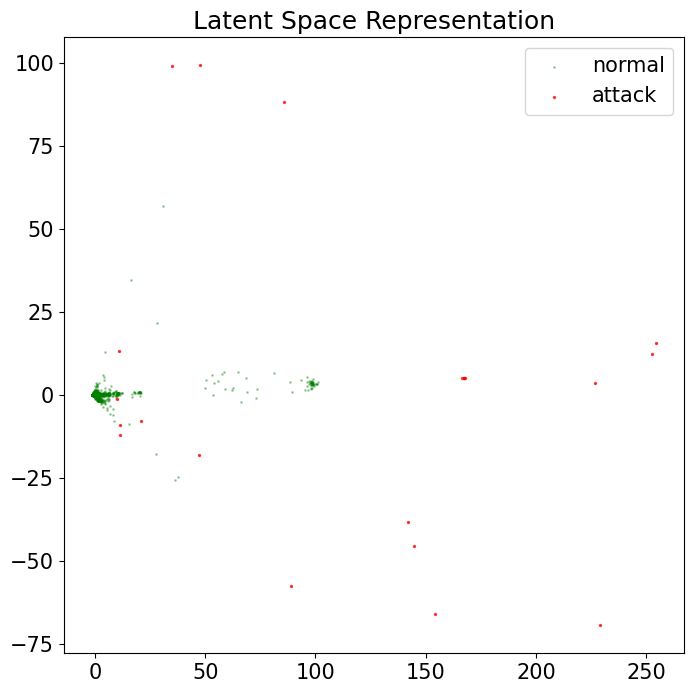

In [72]:
#plot_dist(y_test_scores, color = 'b',title = 'Distribution of anomaly score for Isolation Forest')
#y_test_scores = (y_test_scores - np.min(y_test_scores)) * 100 / (np.max(y_test_scores) - np.min(y_test_scores))
threshold = 60
#threshold = pd.Series(scores).quantile(0.9)
#mapped_list = ['normal' if value == 0 else 'attack' for value in y_test_pred]
anomaly_index = []
labels = ['attack' if score >= threshold else 'normal' for score in y_test_scores]
#labels_conf = ['attack' if score < 0.9 else 'normal' for score in y_test_conf]
for i in range(len(labels)):
    if labels[i]=='attack':
        anomaly_index.append(i)
transfxn.pca_plot(scaler.fit_transform(X_test), labels, palette = ['r', 'lime'])

In [88]:
print(len(y_test_scores))
#normal_index = sorted_score[:len(sorted_score)*3//4]
#normal_data = df_total.iloc[normal_index]
#print(normal_data)
normal_index = []
for idx in range(len(y_test_scores)):
    if y_test_scores[idx]<40 and y_test_conf[idx]==1:
        normal_index.append(idx)
    
#print(normal_index)
print(len(normal_index))

20253
19465


In [ ]:
from joblib import dump, load

# save the model
dump(clf, '../model/AE.joblib')

In [ ]:
X_train_normal = X_train[normal_index]

clf2 = AutoEncoder(epochs=30)
clf2.fit(X_train)

X_test = preprocessing(df_total).to_numpy()
#X_test = np.delete(X_test, 1895, 0)

# get the prediction on the test data
y_test_pred = clf2.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf2.decision_function(X_test)  # outlier scores
y_test_conf = clf2.predict_confidence(X_test)
print(y_test_pred)
print(y_test_scores)
print(y_test_conf)

In [ ]:
threshold = 30
#threshold = pd.Series(scores).quantile(0.9)
#mapped_list = ['normal' if value == 0 else 'attack' for value in y_test_pred]
anomaly_index = []
labels = ['attack' if score >= threshold else 'normal' for score in y_test_scores]
#labels_conf = ['attack' if score < 0.9 else 'normal' for score in y_test_conf]
for i in range(len(labels)):
    if labels[i]=='attack':
        anomaly_index.append(i)
transfxn.pca_plot(scaler.fit_transform(X_test), labels, palette = ['r', 'lime'])

# semi-sup

In [89]:
y_train = []
for i in range(len(y_test_scores)):
    if i in normal_index:
        y_train.append(0)
    elif i in anomaly_index:
        y_train.append(1)
    else:
        y_train.append(-1)

In [75]:
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.semi_supervised import LabelSpreading
from xgboost.sklearn import XGBClassifier

class SemiSupervised:
    """Semi-supervised learning classifiers."""

    def __init__(self):
        """Parameter initialization."""
        pass

    def self_training_clf(
        self,
        base_classifier,
        X_train,
        y_train,
        threshold=None,
        max_iter=None,
        verbose=None,
    ):
        """Train self-training classifier from scikit-learn >= 0.24.1.

        Parameters
        ----------
        base_classifier: supervised classifier implementing
        both fit and predict_proba
        X_train: scaled feature matrix of the training set
        y_train: class label of the training set
        threshold (float):  the decision threshold for
        use with criterion='threshold'. Should be in [0, 1)
        max_iter (int):  maximum number of iterations allowed.
        Should be greater than or equal to 0
        verbose (bool): enable verbose output

        Returns
        -------
        predicted labels and probability
        """
        # self training model
        model = SelfTrainingClassifier(
            base_classifier,
            threshold=threshold,
            max_iter=max_iter,
            verbose=verbose,
        )

        # fit the training set
        model.fit(X_train, y_train)

        # predict the labels of the unlabeled data points
        predicted_labels = model.predict(X_train)

        # predict probability
        predicted_proba = model.predict_proba(X_train)
        return predicted_labels, predicted_proba

    def label_spread(self, X_train, y_train, gamma=None, max_iter=None):
        """Train Label Spreading model from scikit-learn

        Parameters
        ----------
        X_train: scaled training data
        y_train: class label
        gamma: parameter for rbf kernel
        max_iter: maximum number of iterations allowed

        Returns
        -------
        Predicted labels and probability
        """
        # label spreading model
        model = LabelSpreading(
            kernel='rbf', gamma=gamma, max_iter=max_iter, n_jobs=-1
        )

        # fit the training set
        model.fit(X_train, y_train)

        # predict the labels of the unlabeled data points
        predicted_labels = model.transduction_

        # predict probability
        predicted_proba = model.predict_proba(X_train)
        return predicted_labels, predicted_proba

    def eval_metrics(self, y_true, y_pred, model_nm=None):
        """Evaluation metric using the ground truth and the predicted labels.

        Parameters
        ----------
        y_pred: predicted labels
        y_true: true labels
        model_nm: name of classifier

        Returns
        -------
        Performance metrics
        """
        print(f'Test predictions for {str(model_nm)}')
        print('-' * 60)
        print('Accuracy:  %f' % (accuracy_score(y_true, y_pred)))
        print('AUROC: %f' % (roc_auc_score(y_true, y_pred)))
        print('AUPRC: %f' % (average_precision_score(y_true, y_pred)))
        print('Predicted classes:', np.unique(y_pred))
        print('Confusion matrix:\n', confusion_matrix(y_true, y_pred))
        print(
            'Classification report:\n', classification_report(y_true, y_pred)
        )
        print('-' * 60)

    def plot_varying_threshold(self, base_classifier, X_train, y_train):
        """Plot the effect of varying threshold for self-training.

        Parameters
        ----------
        base_classifier: supervised classifier implementing
        both fit and predict_proba
        X_train: scaled feature matrix of the training set
        y_train: class label of the training set

        Returns
        -------
        Matplotlib figure
        """
        total_samples = y_train.shape[0]
        x_values = np.arange(0.4, 1.05, 0.05)
        x_values = np.append(x_values, 0.99999)
        no_labeled = np.zeros(x_values.shape[0])
        no_iterations = np.zeros(x_values.shape[0])
        for (i, threshold) in enumerate(x_values):
            # fit model with chosen base classifier
            self_training_clf = SelfTrainingClassifier(
                base_classifier, threshold=threshold
            )
            self_training_clf.fit(X_train, y_train)

            # the number of labeled samples that the classifier
            # has available by the end of fit
            no_labeled[i] = (
                total_samples
                - np.unique(
                    self_training_clf.labeled_iter_, return_counts=True
                )[1][0]
            )

            # the last iteration the classifier labeled a sample in
            no_iterations[i] = np.max(self_training_clf.labeled_iter_)

        # plot figures
        plt.rcParams.update({'font.size': 15})
        _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
        ax1.plot(x_values, no_labeled, color='b')
        ax1.set_xlabel('Threshold')
        ax1.set_ylabel('Number of labeled samples')
        ax2.plot(x_values, no_iterations, color='b')
        ax2.set_ylabel('Number of iterations')
        ax2.set_xlabel('Threshold')
        plt.show()

In [90]:
model = SemiSupervised()
X_train = preprocessing(df_total)

In [85]:
lr_base_classifier = LogisticRegression(random_state = 42)
y_pred, y_proba = model.self_training_clf(
    lr_base_classifier, X_train, y_train,
    threshold=0.75, max_iter=None,verbose=True
)

End of iteration 1, added 781 new labels.


In [52]:
param_dist = {'objective':'binary:logistic', 'eval_metric':'logloss', 
              'n_estimators':100, 'learning_rate':0.1, 'random_state':42
            }
xgb_base_classifier = XGBClassifier(**param_dist)
y_pred, y_proba = model.self_training_clf(xgb_base_classifier, X_train, y_train,
                                          threshold= 0.75, max_iter = None,verbose = True)

End of iteration 1, added 3445 new labels.
End of iteration 2, added 80 new labels.
End of iteration 3, added 44 new labels.


In [91]:
param_dist = {'n_estimators':100, 'random_state':42}
rf_base_classifier = RandomForestClassifier(**param_dist)
y_pred, y_proba = model.self_training_clf(
    rf_base_classifier, X_train, y_train,
    threshold=0.9, max_iter=None,verbose=True
)

End of iteration 1, added 713 new labels.
End of iteration 2, added 1 new labels.
End of iteration 3, added 1 new labels.
End of iteration 4, added 2 new labels.
End of iteration 5, added 1 new labels.


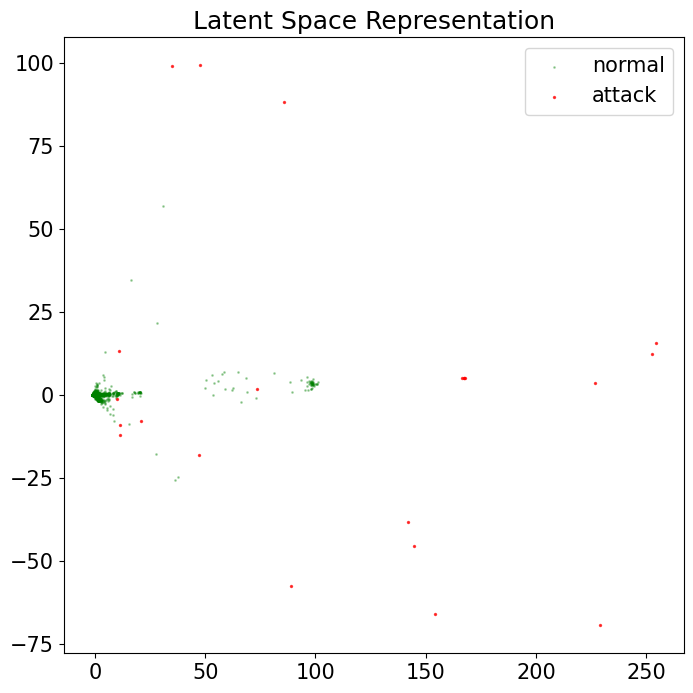

In [92]:
labels = ['attack' if score == 1 else 'normal' for score in y_pred]

transfxn.pca_plot(scaler.fit_transform(X_train), labels, palette = ['r', 'lime'])

In [79]:
for i in range(97,100):
    y_train[i] = 0

In [80]:
y_pred, y_proba = model.self_training_clf(rf_base_classifier, X_train, y_train,
                                          threshold= 0.9, max_iter = None,verbose = True)

End of iteration 1, added 1120 new labels.
End of iteration 2, added 15 new labels.
End of iteration 3, added 4 new labels.
End of iteration 4, added 1 new labels.


In [55]:
y_pred, y_proba = model.self_training_clf(xgb_base_classifier, X_train, y_train,
                                          threshold= 0.75, max_iter = None,verbose = True)

End of iteration 1, added 3445 new labels.
End of iteration 2, added 80 new labels.
End of iteration 3, added 44 new labels.


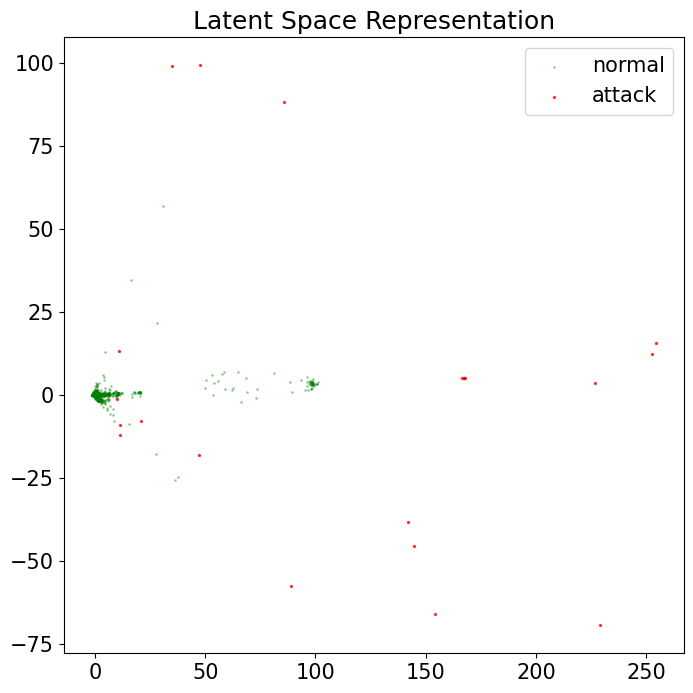

In [81]:
labels = ['attack' if score == 1 else 'normal' for score in y_pred]

transfxn.pca_plot(scaler.fit_transform(X_train), labels, palette = ['r', 'lime'])

In [ ]:
len([score for score in y_pred if score==1])

In [ ]:
for i in range(len(y_pred)):
    if y_pred[i] == 1:
        print(i)

In [ ]:
preprocessing(df_total).iloc[1137:1143, 50:60]